## Contour plots of tracer concentration on shelf bottom for several initial profiles without canyon lid

Map hcw on shelf by looking at bottom cells and multiplying their concentration by their area.


The algorithm:

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import matplotlib.cm as cm

import matplotlib as mpl

from math import *

from mpl_toolkits.mplot3d.axes3d import Axes3D

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns


In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import savitzky_golay as sg

In [3]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [23]:
#Base case, iso =1 , No 3d diff.
#CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

NoCCanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/gridGlob.nc'
NoCCanyonGridOut = Dataset(NoCCanyonGrid)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

Ptracer='/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'
PtracerOut = Dataset(Ptracer)

PtracerBase='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'

PtracerNoC='/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'
PtracerNoCOut = Dataset(PtracerNoC)

PtracerNoCBase='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'


In [5]:
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
bathy = rout.getField(CanyonGrid, 'Depth')
bathyNoC = rout.getField(NoCCanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(NoCCanyonGrid, 'HFacC')
MaskCNoC = rout.getMask(NoCCanyonGrid, 'HFacC')
rANoC = rout.getField(NoCCanyonGrid, 'rA')
rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

In [24]:
Tr01 = rout.getField(PtracerBase,'Tr1') # 
Tr02 = rout.getField(Ptracer,'Tr02') # 
Tr03 = rout.getField(Ptracer,'Tr03') # 

In [7]:
Tr04 = rout.getField(Ptracer,'Tr04') # 
Tr05 = rout.getField(Ptracer,'Tr05') # 
Tr06 = rout.getField(Ptracer,'Tr06') # 

In [8]:
Tr07 = rout.getField(Ptracer,'Tr07') # 
Tr08 = rout.getField(Ptracer,'Tr08') # 

In [9]:
#Tr01noc = rout.getField(PtracerNoC,'Tr01') # 
#Tr02noc = rout.getField(PtracerNoC,'Tr02') # 
#Tr03noc = rout.getField(PtracerNoC,'Tr03') # 

In [10]:
#Tr04noc = rout.getField(PtracerNoC,'Tr04') # 
#Tr05noc = rout.getField(PtracerNoC,'Tr05') # 
#Tr06noc = rout.getField(PtracerNoC,'Tr06') # 

In [11]:
#Tr07noc = rout.getField(PtracerNoC,'Tr07') # 
#Tr08noc = rout.getField(PtracerNoC,'Tr08') # 

In [12]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                ConcArea[tt,i,j] = TrBottom*ra[i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    #ConcAreaMasked = np.ma.masked_values(ConcDepths,-2.5)
    #ConcDepths[np.where(np.ma.getmask(ConcDepthsMasked)==True)] = np.nan

    return (ConcArea,
            np.ma.masked_array(Conc, mask=maskShelf),
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

In [25]:
ConcArea1, Conc1, Conc1Filt, Area1 = ConcArea(Tr01, hFacC, rA, bathy)

(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


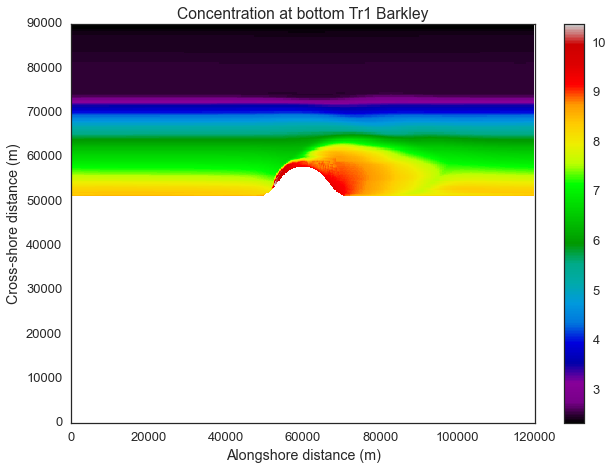

In [26]:
sns.set_context('talk',font_scale=1.0)
plt.pcolor(xc[1,:],yc[:,1],Conc1Filt[10,:,:],cmap='spectral')
cbar = plt.colorbar()
plt.title('Concentration at bottom Tr1 Barkley')
plt.ylabel('Cross-shore distance (m)')
plt.xlabel('Alongshore distance (m)')

In [15]:
ConcArea2, Conc2, Conc2Filt, Area2 = ConcArea(Tr02, hFacC, rA, bathy)
ConcArea3, Conc3, Conc3Filt, Area3 = ConcArea(Tr03, hFacC, rA, bathy)
ConcArea4, Conc4, Conc4Filt, Area4 = ConcArea(Tr04, hFacC, rA, bathy)
ConcArea5, Conc5, Conc5Filt, Area5 = ConcArea(Tr05, hFacC, rA, bathy)
ConcArea6, Conc6, Conc6Filt, Area6 = ConcArea(Tr06, hFacC, rA, bathy)
ConcArea7, Conc7, Conc7Filt, Area7 = ConcArea(Tr07, hFacC, rA, bathy)
ConcArea8, Conc8, Conc8Filt, Area8 = ConcArea(Tr08, hFacC, rA, bathy)

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [16]:
#ConcArea2noc, Conc2noc, Area2noc = ConcArea(Tr02noc, hFacCNoC, rANoC, bathyNoC)
#ConcArea3noc, Conc3noc, Area3noc = ConcArea(Tr03noc, hFacCNoC, rANoC, bathyNoC)
#ConcArea4noc, Conc4noc, Area4noc = ConcArea(Tr04noc, hFacCNoC, rANoC), bathyNoC
#ConcArea5noc, Conc5noc, Area5noc = ConcArea(Tr05noc, hFacCNoC, rANoC, bathyNoC)
#ConcArea6noc, Conc6noc, Area6noc = ConcArea(Tr06noc, hFacCNoC, rANoC, bathyNoC)
#ConcArea7noc, Conc7noc, Area7noc = ConcArea(Tr07noc, hFacCNoC, rANoC, bathyNoC)
#ConcArea8noc, Conc8noc, Area8noc = ConcArea(Tr08noc, hFacCNoC, rANoC, bathyNoC)

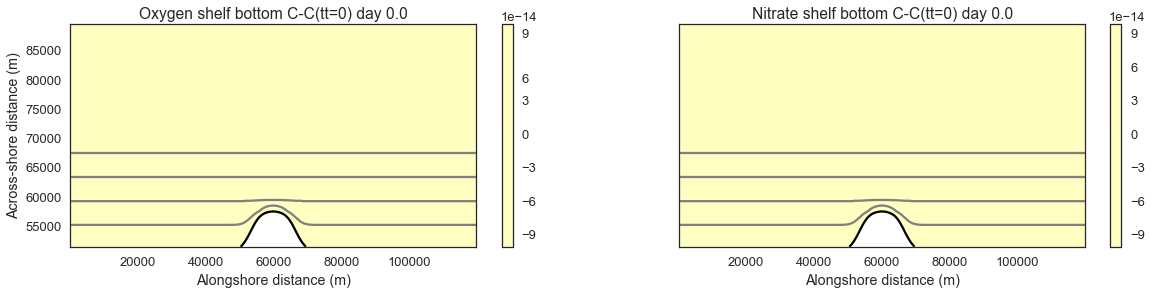

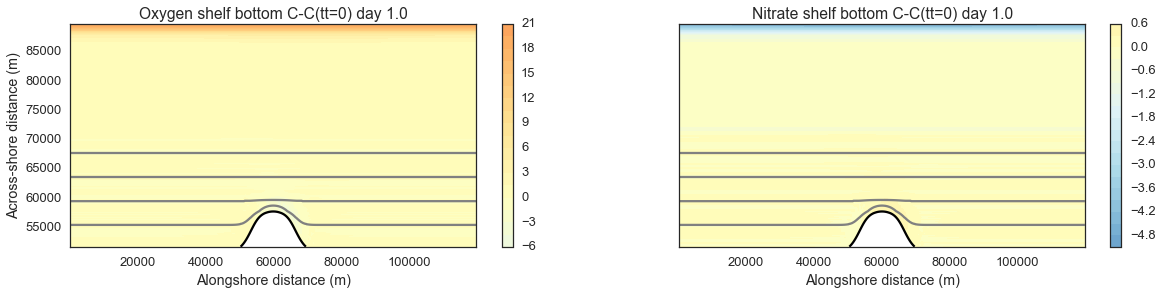

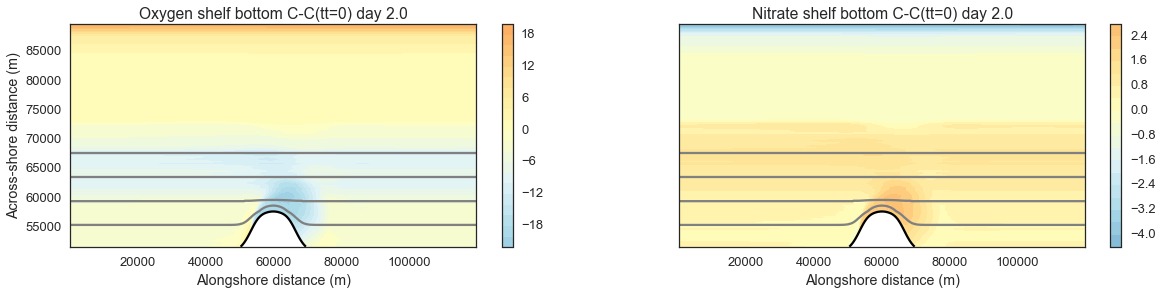

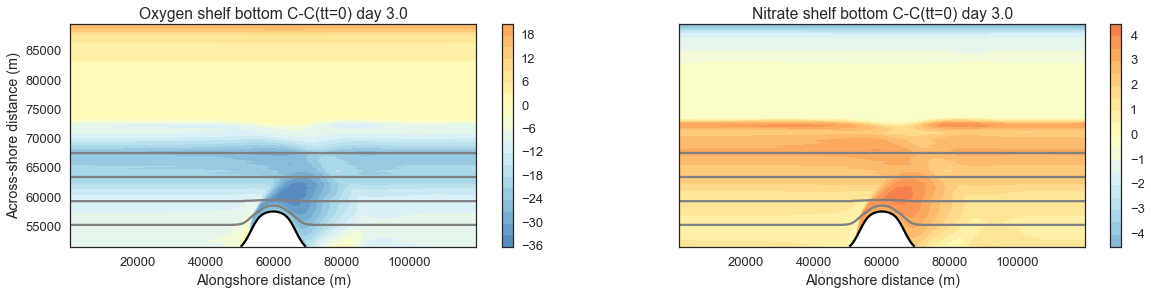

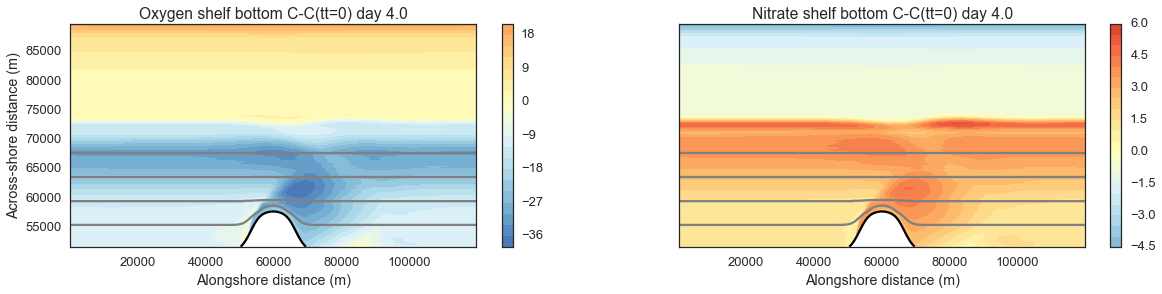

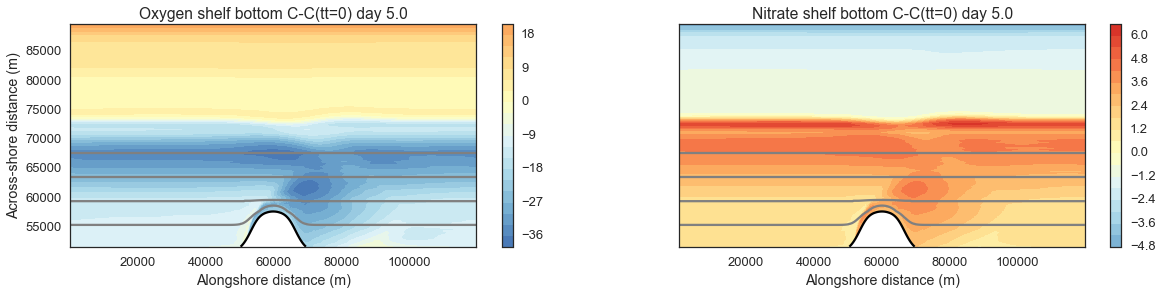

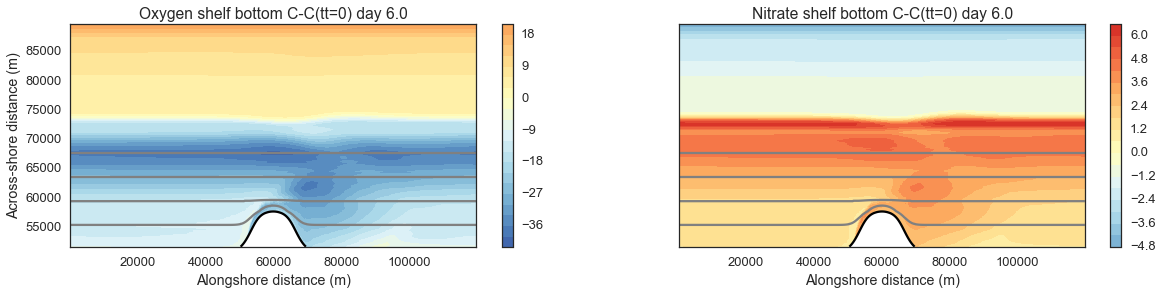

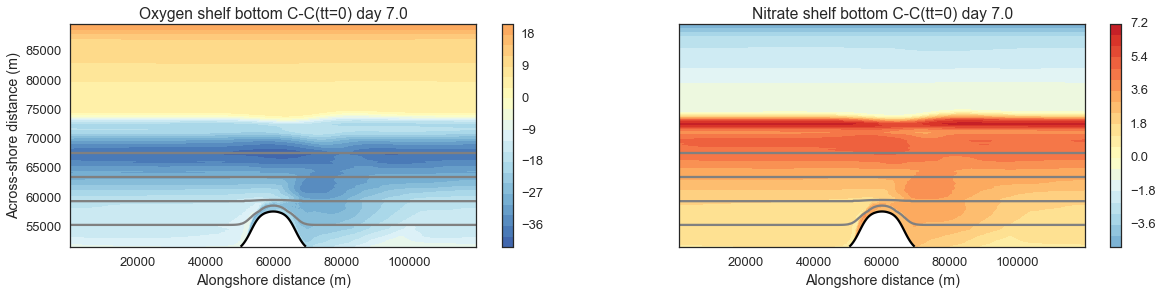

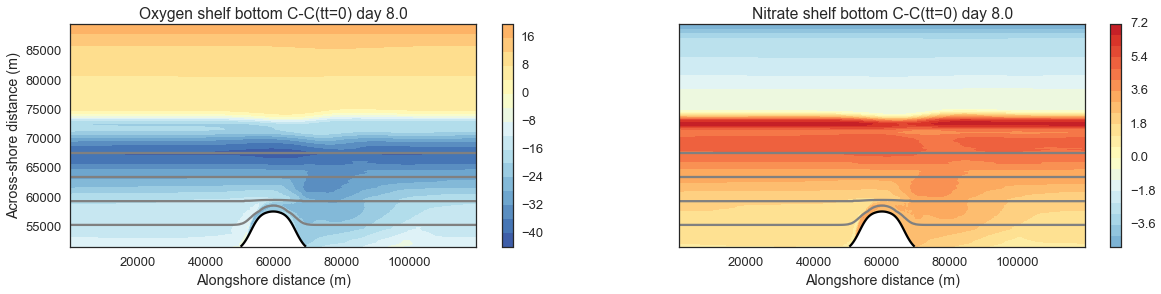

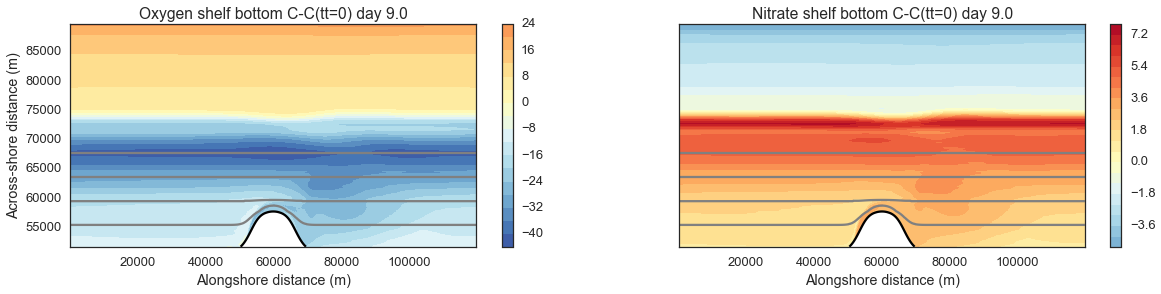

In [17]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    
    fig,((ax1),(ax2)) = plt.subplots(1, 2, figsize=(20, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:,:],yc[227:,:],
                       Conc3Filt[tt,227:,:]-Conc3Filt[0,227:,:],20,
                       vmin = -48.0, vmax = 48.0, cmap='RdYlBu_r',
                      )
    cb = plt.colorbar(iso, shrink=1,ax=ax1)
    #cb.set_label('')
    cset = ax1.contour(xc[227:,:],yc[227:,:],-bathy[227:,:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )

    ax1.set_aspect('auto')
    ax1.set_title('Oxygen shelf bottom C-C(tt=0) day %0.1f ' %(tt/2.0))
    ax1.set_ylabel('Across-shore distance (m)')
    ax1.set_xlabel('Alongshore distance (m)')
    
    iso2 = ax2.contourf(xc[227:,:],yc[227:,:],
                        Conc4Filt[tt,227:,:]-Conc4Filt[0,227:,:],20,
                        vmin = -8.0, vmax = 8.0 , cmap='RdYlBu_r',
                       )
    cb2 = plt.colorbar(iso2, shrink=1,ax=ax2)
    #cb2.set_label('m')
    cset = ax2.contour(xc[227:,:],yc[227:,:],-bathy[227:,:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )

    ax2.set_aspect('auto')
    ax2.set_title('Nitrate shelf bottom C-C(tt=0) day %0.1f ' %(tt/2.0))
    #ax2.set_ylabel('Across-shore distance (m)')
    ax2.set_xlabel('Alongshore distance (m)')
    
    plt.tight_layout
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')

Note that I used the flat shelf mask to find the "shelf bottom". This means that the region over the canyon is the concentration*area over the lid of the canyon.

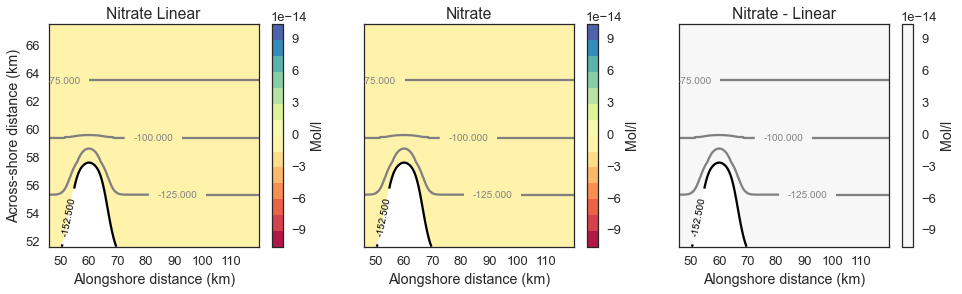

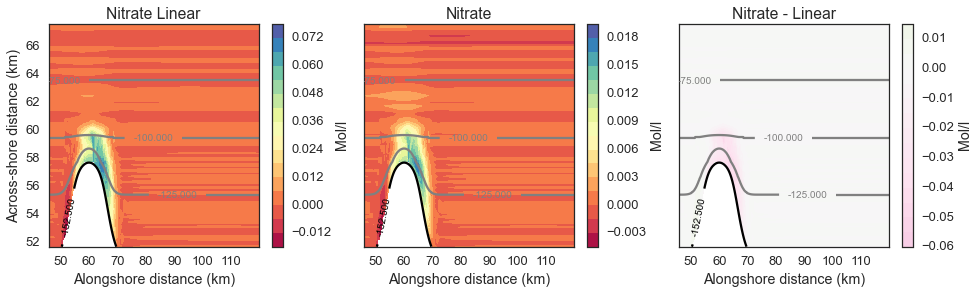

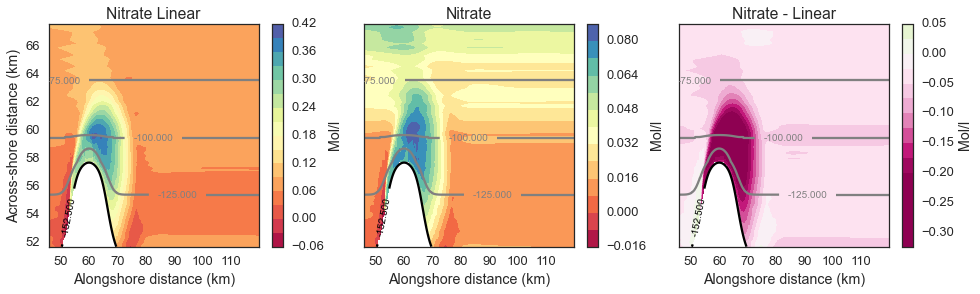

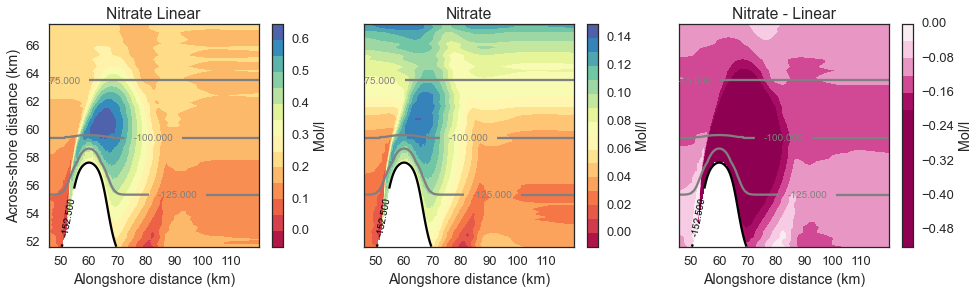

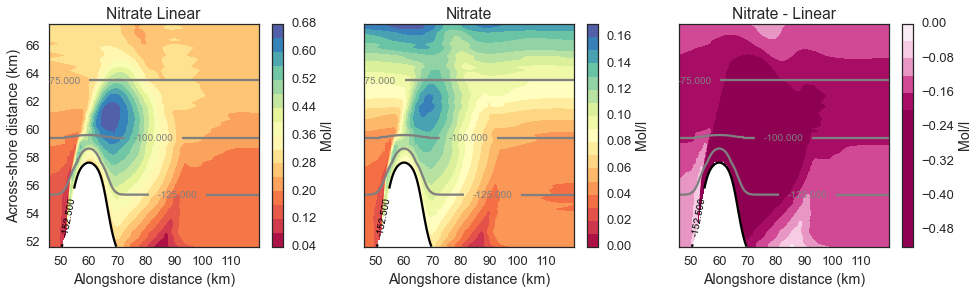

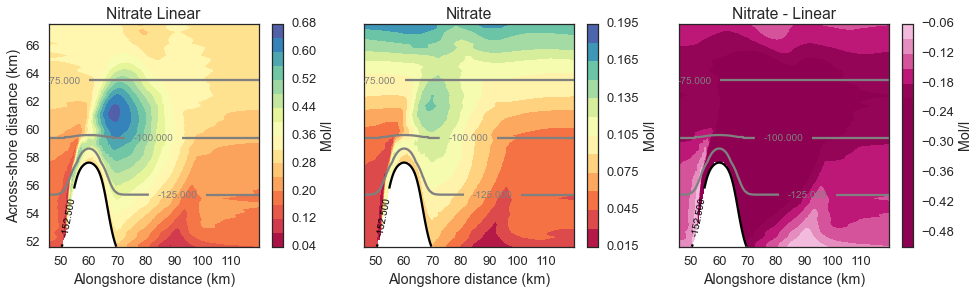

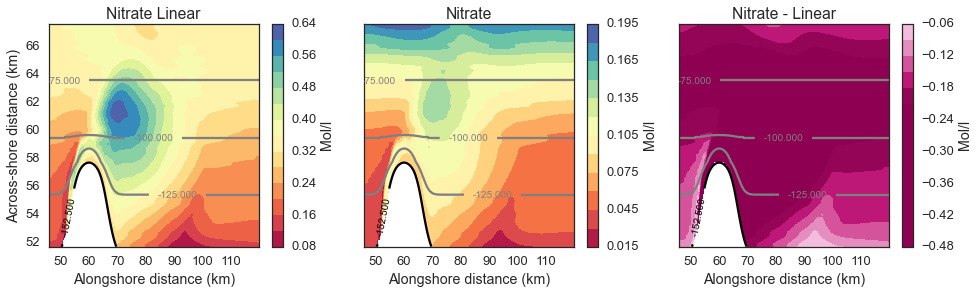

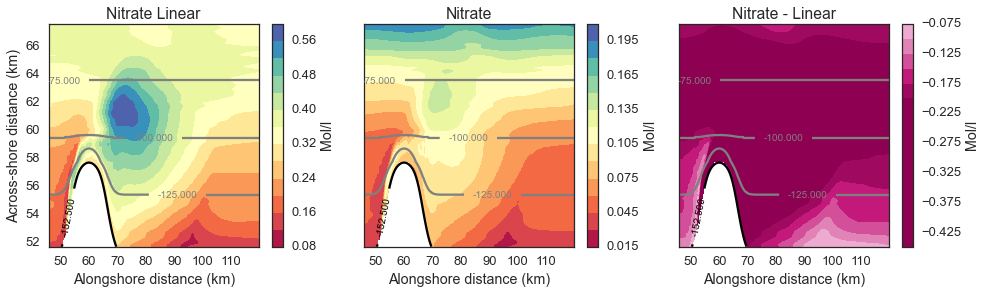

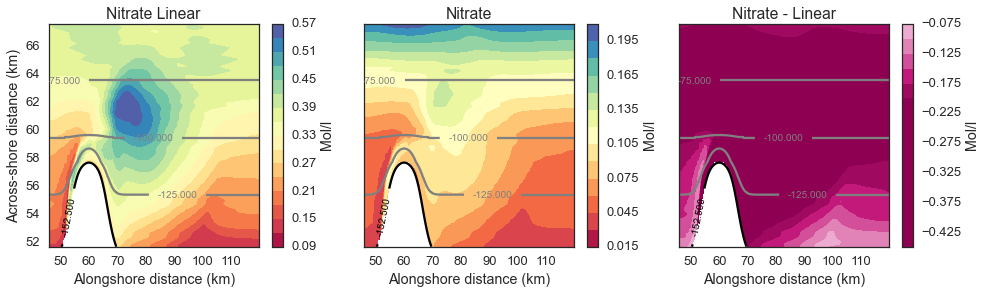

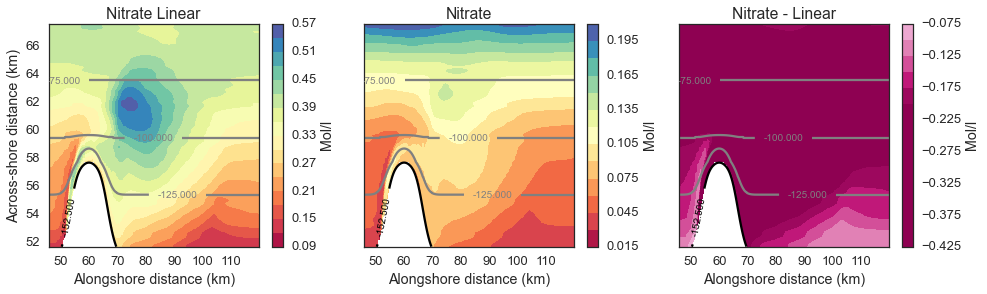

In [27]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    
    fig,((ax1),(ax2),(ax3)) = plt.subplots(1, 3, figsize=(16, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       (Conc1Filt[tt,227:300,100:]-Conc1Filt[0,227:300,100:])/Conc1Filt[0,227:300,100:],
                       15,
                       cmap='Spectral',
                      )
    
    cax,kw = mpl.colorbar.make_axes([ax1],location='right',shrink=1)
    cb = plt.colorbar(iso, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax1.clabel(cset, inline=1, fontsize=10)
    
    ax1.set_aspect('auto')
    ax1.set_title('Nitrate Linear')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc4Filt[tt,227:300,100:]-Conc4Filt[0,227:300,100:])/Conc4Filt[0,227:300,100:],
                        15,
                        cmap='Spectral',
                       )
    cax,kw = mpl.colorbar.make_axes([ax2],location='right',shrink=1)
    cb = plt.colorbar(iso2, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax2.clabel(cset, inline=1, fontsize=10)
    
    ax2.set_aspect('auto')
    ax2.set_title('Nitrate')
    ax2.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        ((Conc4Filt[tt,227:300,100:]/Conc4Filt[0,227:300,100:])
                         - Conc1Filt[tt,227:300,100:]/Conc1Filt[0,227:300,100:]),
                        15, vmin = -0.2, vmax = 0.2, cmap='PiYG',
                       )
    cax,kw = mpl.colorbar.make_axes([ax3],location='right',shrink=1)
    cb = plt.colorbar(iso3, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax3.clabel(cset, inline=1, fontsize=10)
    
    ax3.set_aspect('auto')
    ax3.set_title('Nitrate - Linear ' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    #plt.tight_layout()
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')

0
2
4
6
8
10
12
14
16
18


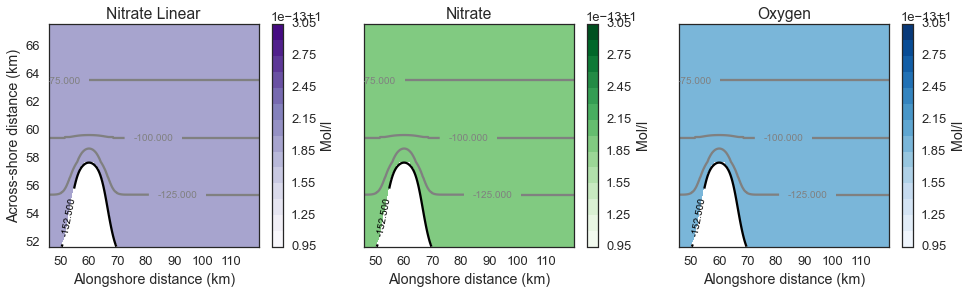

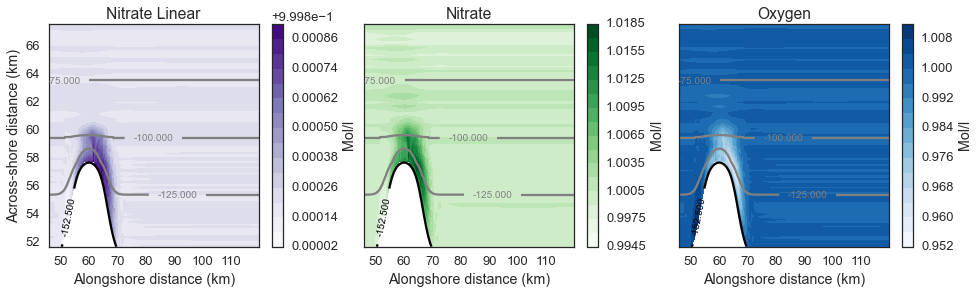

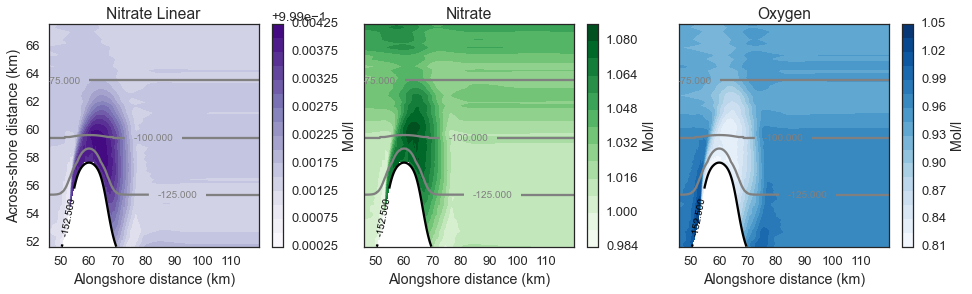

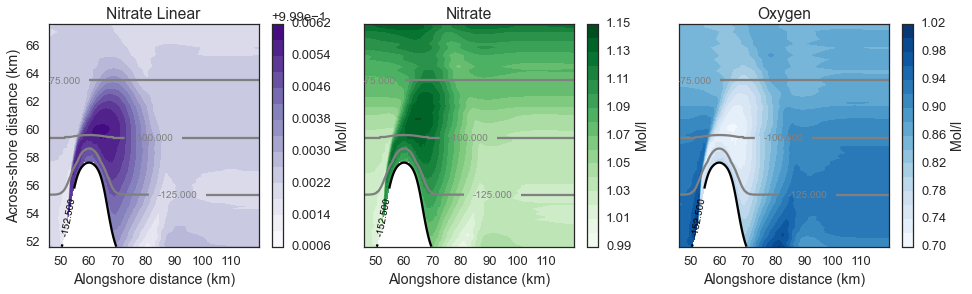

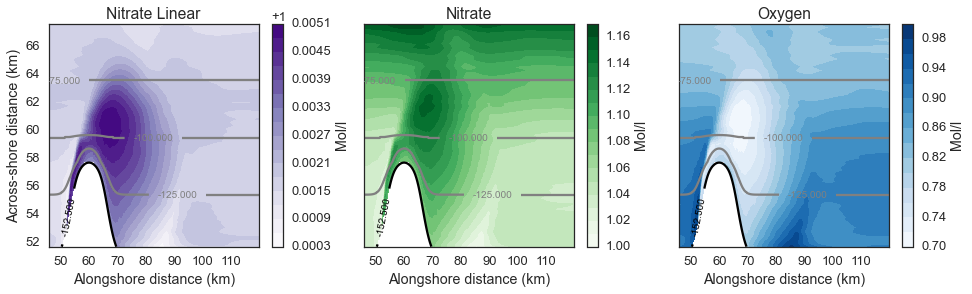

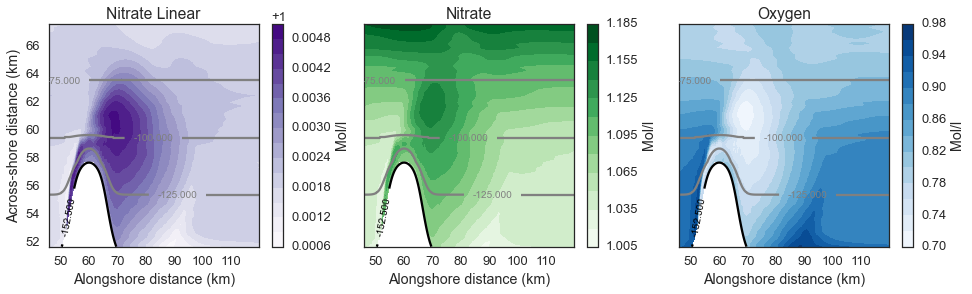

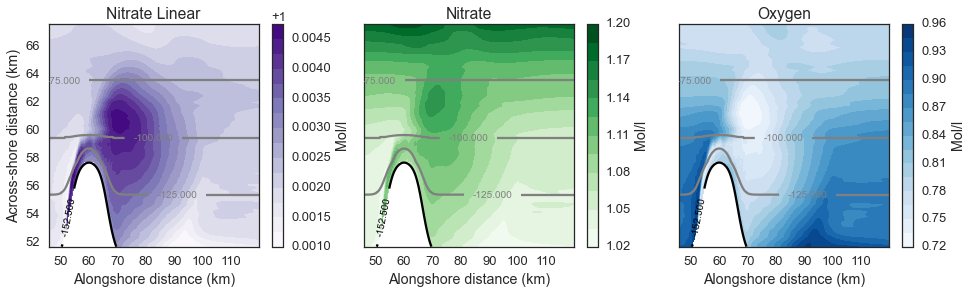

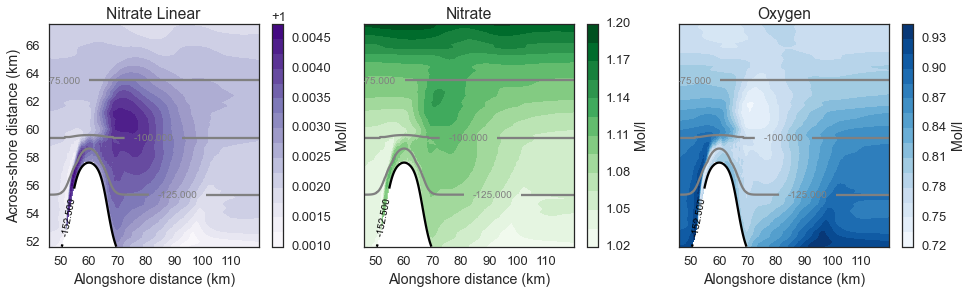

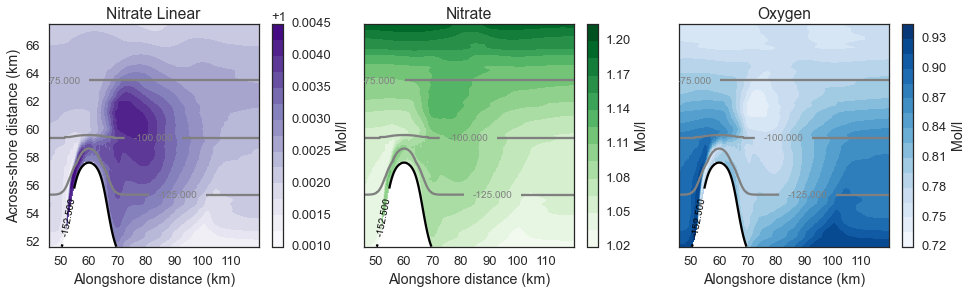

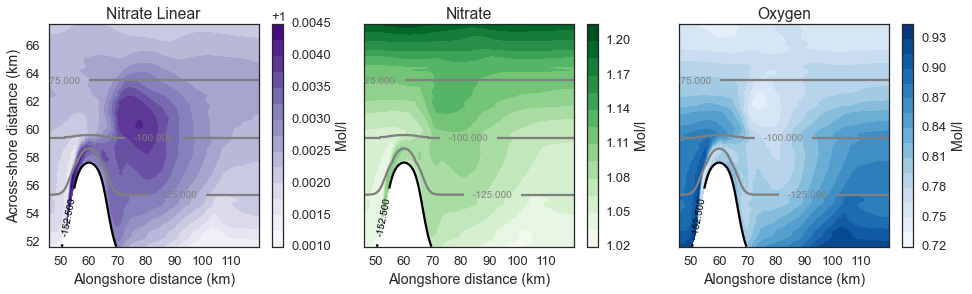

In [19]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    print(tt)
    fig,((ax1),(ax2),(ax3)) = plt.subplots(1, 3, figsize=(16, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       (Conc1Filt[tt,227:300,100:])/Conc1Filt[0,227:300,100:],
                       15,
                       cmap='Purples',
                      )
    
    cax,kw = mpl.colorbar.make_axes([ax1],location='right',shrink=1)
    cb = plt.colorbar(iso, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax1.clabel(cset, inline=1, fontsize=10)
    
    ax1.set_aspect('auto')
    ax1.set_title('Nitrate Linear')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc4Filt[tt,227:300,100:])/Conc4Filt[0,227:300,100:],
                        15,cmap='Greens',
                       )
    cax,kw = mpl.colorbar.make_axes([ax2],location='right',shrink=1)
    cb = plt.colorbar(iso2, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [  rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax2.clabel(cset, inline=1, fontsize=10)
    
    ax2.set_aspect('auto')
    ax2.set_title('Nitrate')
    ax2.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc3Filt[tt,227:300,100:])/Conc3Filt[0,227:300,100:],
                        15, cmap='Blues',
                       )
    cax,kw = mpl.colorbar.make_axes([ax3],location='right',shrink=1)
    cb = plt.colorbar(iso3, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax3.clabel(cset, inline=1, fontsize=10)
    
    ax3.set_aspect('auto')
    ax3.set_title('Oxygen' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    #plt.tight_layout()
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')

0
2
4
6
8
10
12
14
16
18


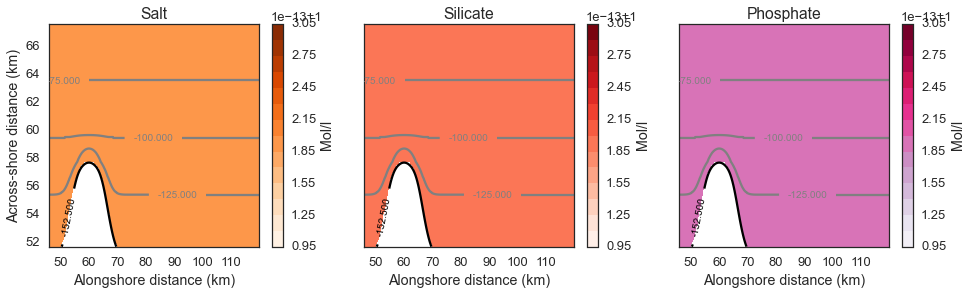

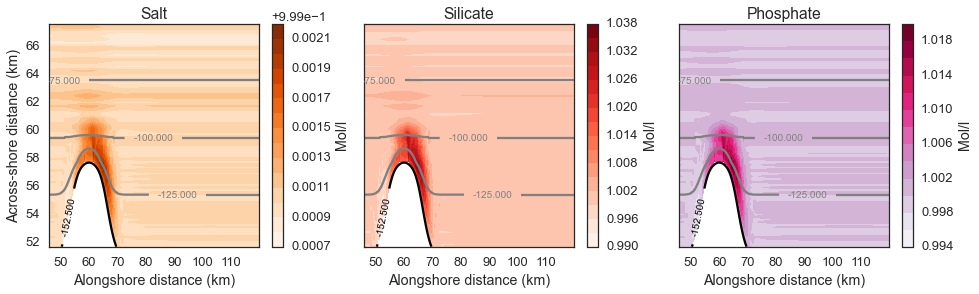

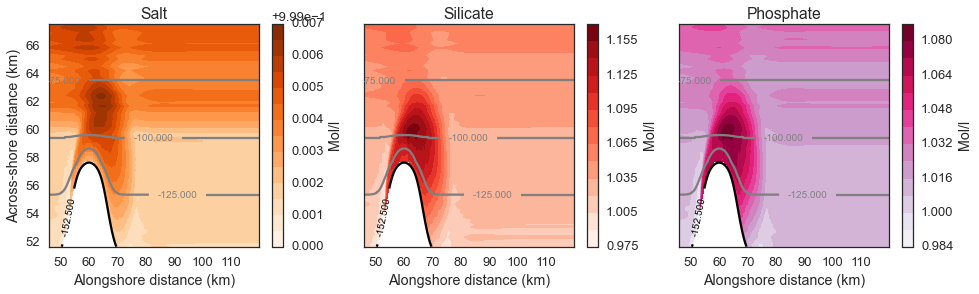

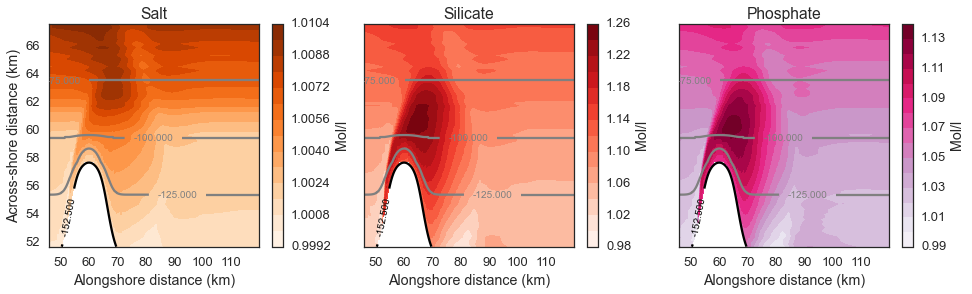

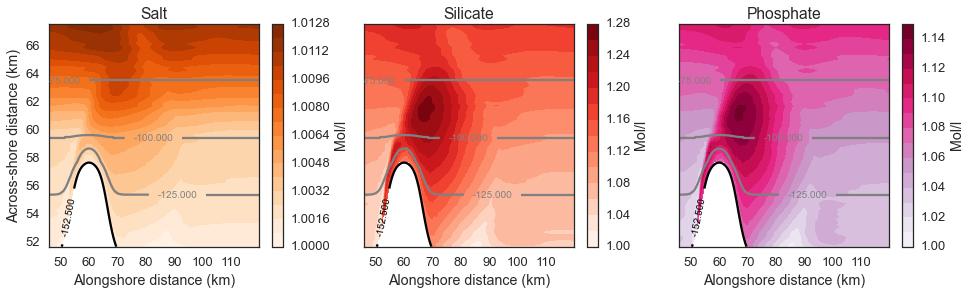

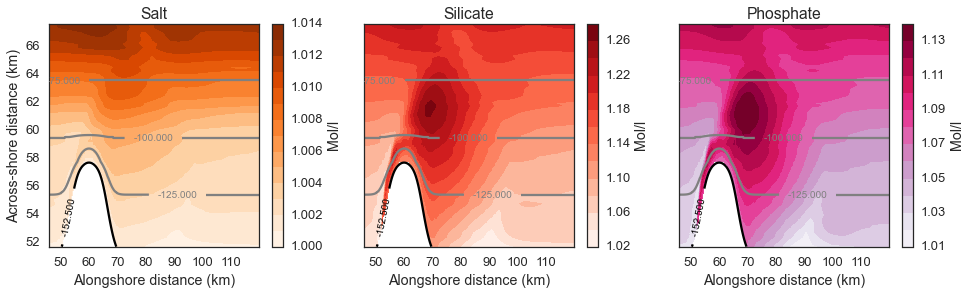

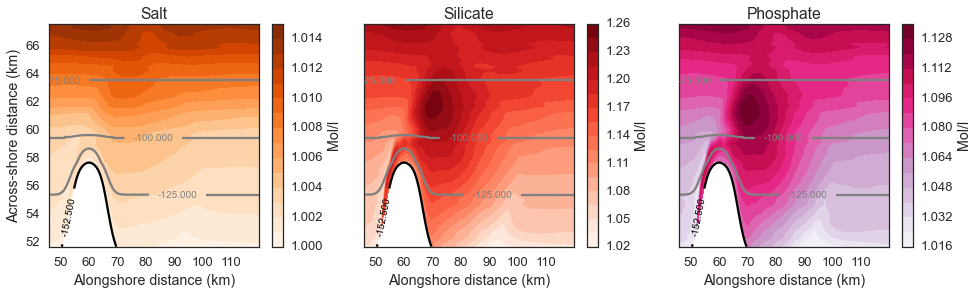

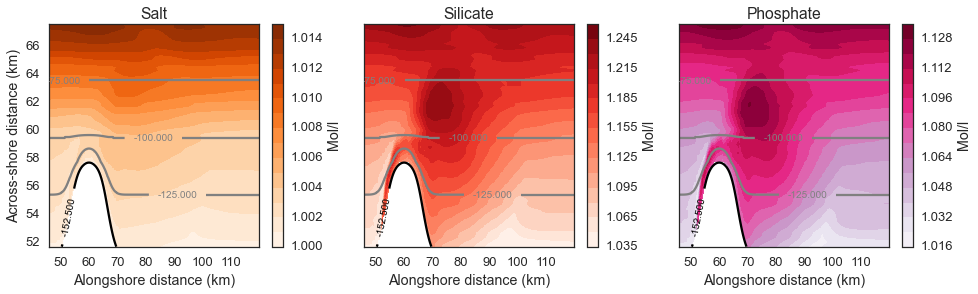

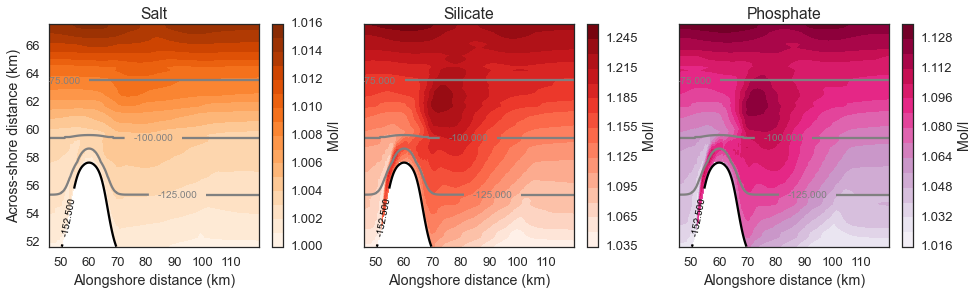

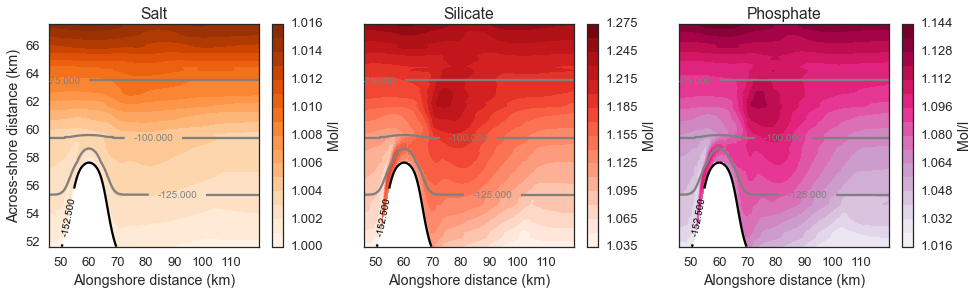

In [20]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    print(tt)
    fig,((ax1),(ax2),(ax3)) = plt.subplots(1, 3, figsize=(16, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       (Conc2Filt[tt,227:300,100:])/Conc2Filt[0,227:300,100:],
                       15,
                       cmap='Oranges',
                      )
    
    cax,kw = mpl.colorbar.make_axes([ax1],location='right',shrink=1)
    cb = plt.colorbar(iso, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax1.clabel(cset, inline=1, fontsize=10)
    
    ax1.set_aspect('auto')
    ax1.set_title('Salt')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc5Filt[tt,227:300,100:])/Conc5Filt[0,227:300,100:],
                        15,cmap='Reds',
                       )
    cax,kw = mpl.colorbar.make_axes([ax2],location='right',shrink=1)
    cb = plt.colorbar(iso2, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [  rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax2.clabel(cset, inline=1, fontsize=10)
    
    ax2.set_aspect('auto')
    ax2.set_title('Silicate')
    ax2.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc6Filt[tt,227:300,100:])/Conc6Filt[0,227:300,100:],
                        15, cmap='PuRd')
    cax,kw = mpl.colorbar.make_axes([ax3],location='right',shrink=1)
    cb = plt.colorbar(iso3, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax3.clabel(cset, inline=1, fontsize=10)
    
    ax3.set_aspect('auto')
    ax3.set_title('Phosphate' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    #plt.tight_layout()
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')

0
2
4
6
8
10
12
14
16
18


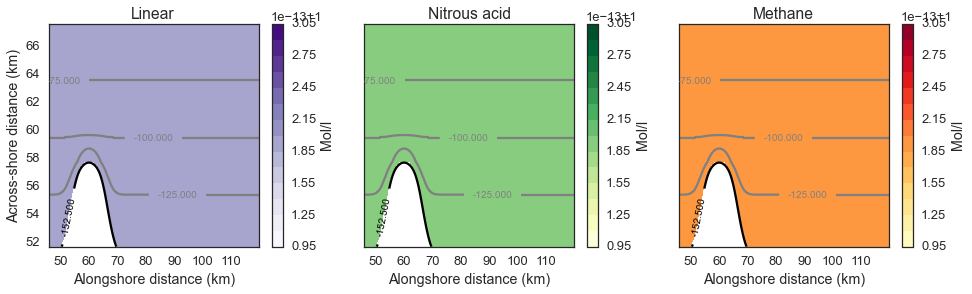

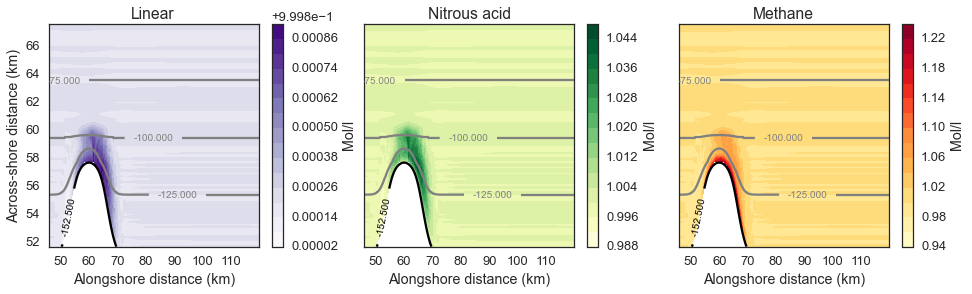

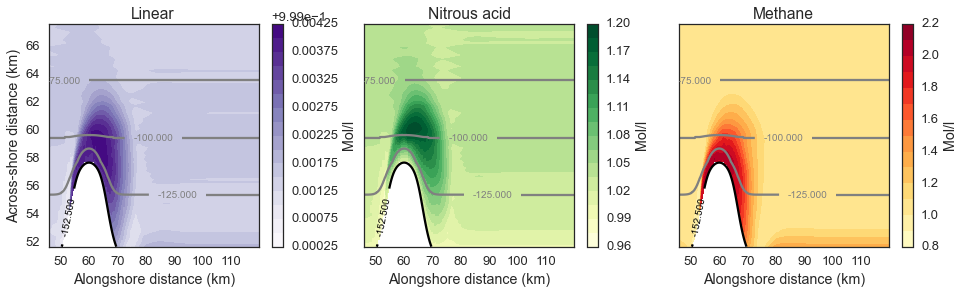

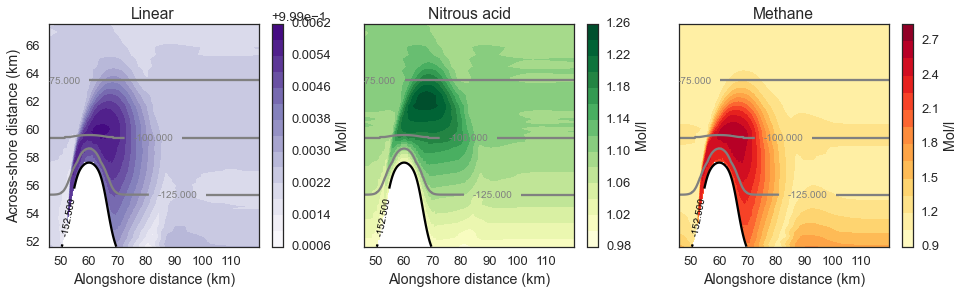

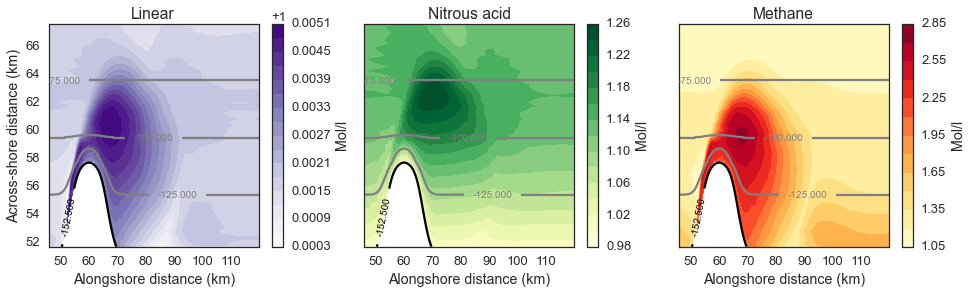

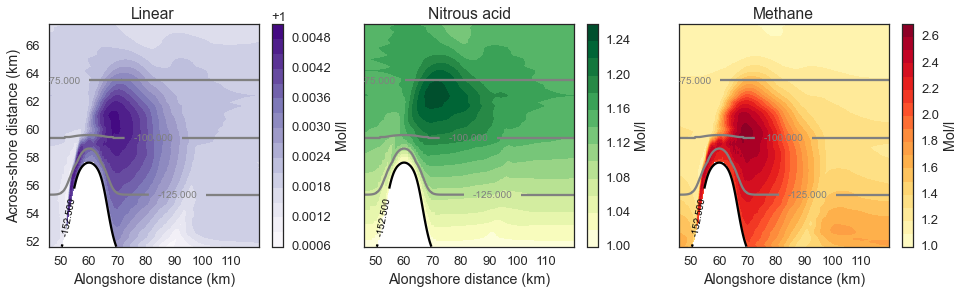

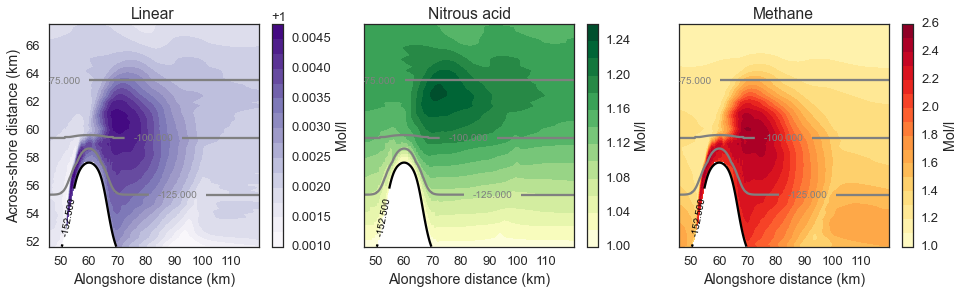

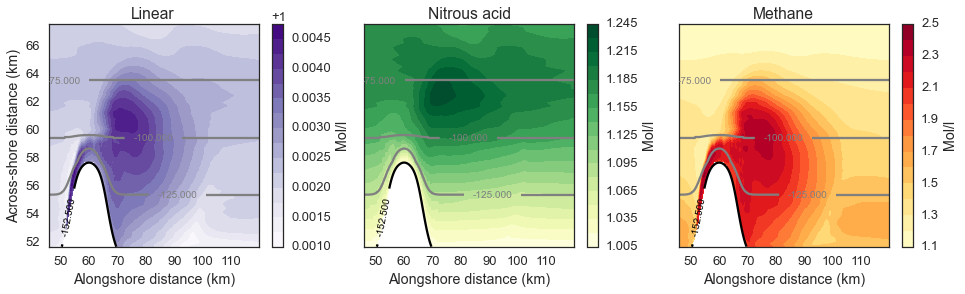

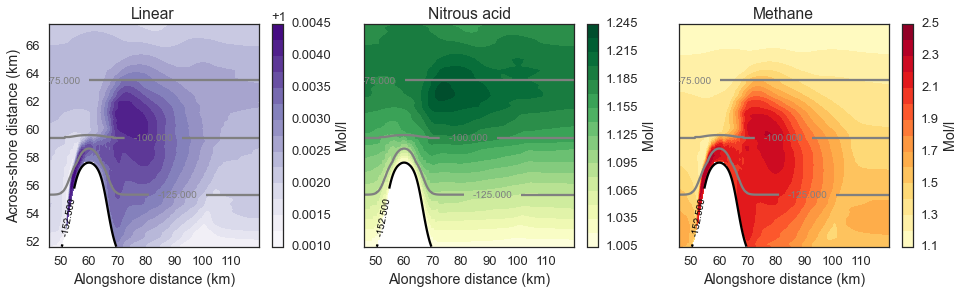

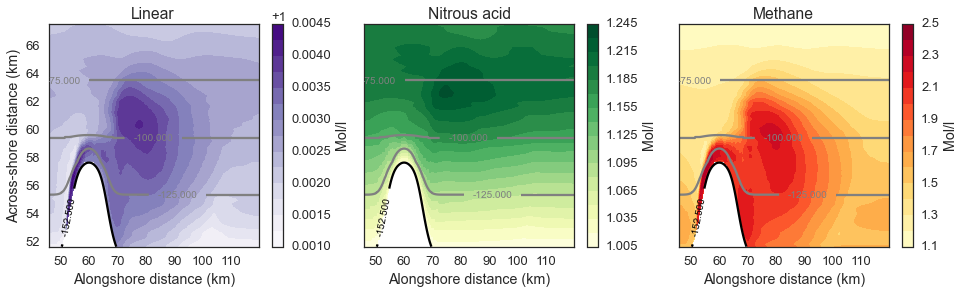

In [21]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    print(tt)
    fig,((ax1),(ax2),(ax3)) = plt.subplots(1, 3, figsize=(16, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       (Conc1Filt[tt,227:300,100:])/Conc1Filt[0,227:300,100:],
                       15,
                       cmap='Purples',
                      )
    
    cax,kw = mpl.colorbar.make_axes([ax1],location='right',shrink=1)
    cb = plt.colorbar(iso, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax1.clabel(cset, inline=1, fontsize=10)
    
    ax1.set_aspect('auto')
    ax1.set_title('Linear')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc7Filt[tt,227:300,100:])/Conc7Filt[0,227:300,100:],
                        15,cmap='YlGn',
                       )
    cax,kw = mpl.colorbar.make_axes([ax2],location='right',shrink=1)
    cb = plt.colorbar(iso2, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax2.clabel(cset, inline=1, fontsize=10)
    
    ax2.set_aspect('auto')
    ax2.set_title('Nitrous acid')
    ax2.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc8Filt[tt,227:300,100:])/Conc8Filt[0,227:300,100:],
                        15, cmap='YlOrRd',
                       )
    cax,kw = mpl.colorbar.make_axes([ax3],location='right',shrink=1)
    cb = plt.colorbar(iso3, cax=cax,**kw)
    cb.set_label('Mol/l')
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax3.clabel(cset, inline=1, fontsize=10)
    
    ax3.set_aspect('auto')
    ax3.set_title('Methane' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    #plt.tight_layout()
    plt.show

#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')

0
2
4
6
8
10
12
14
16
18


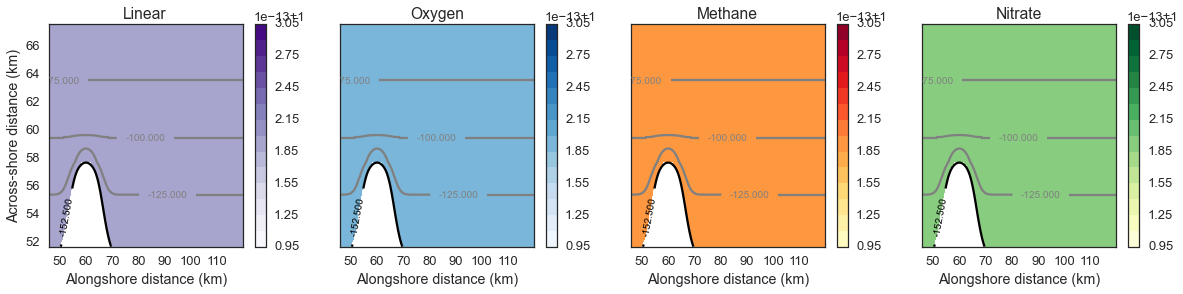

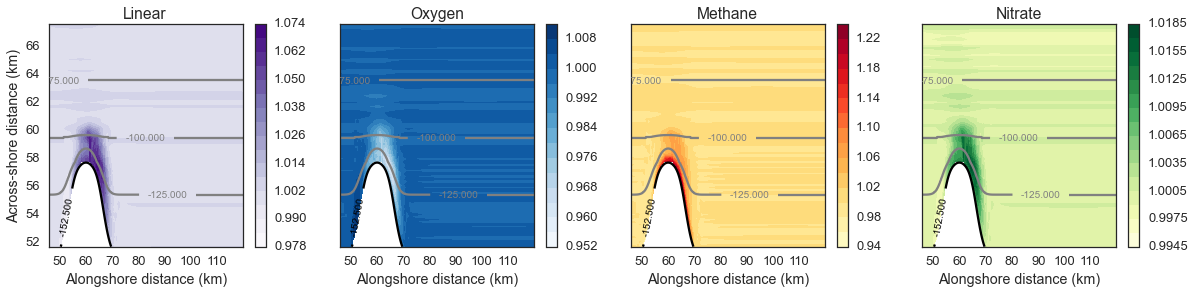

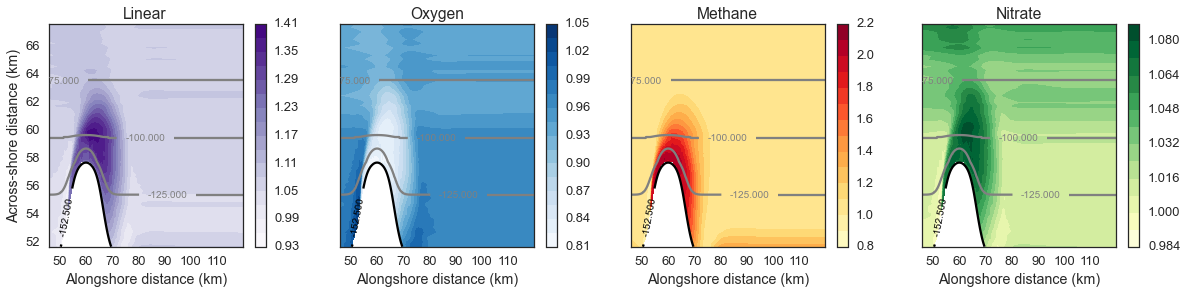

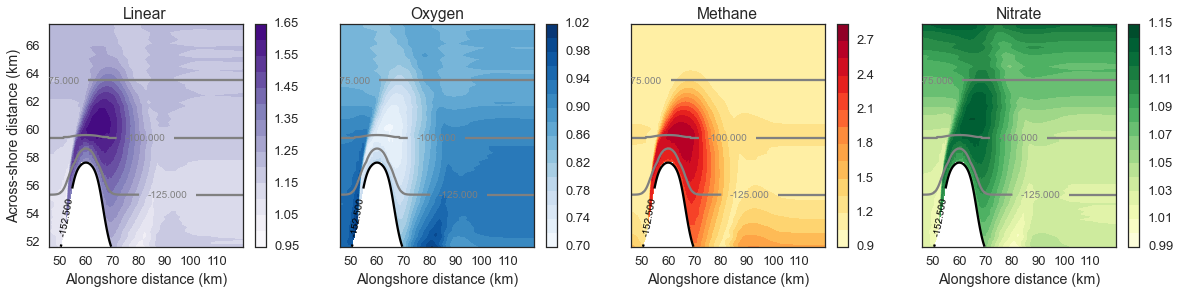

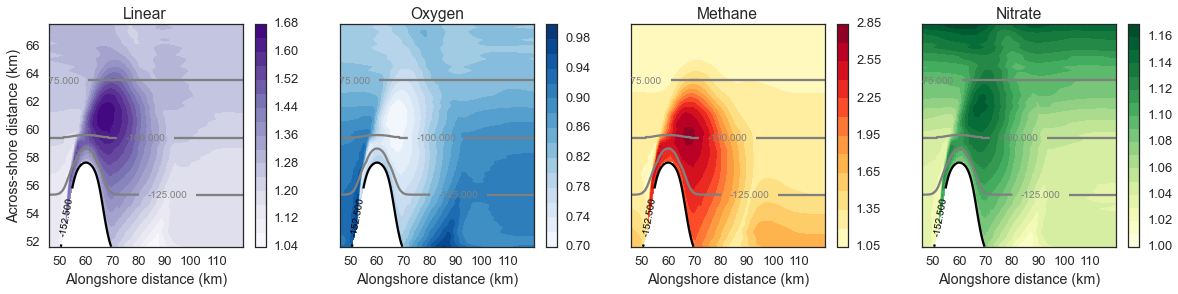

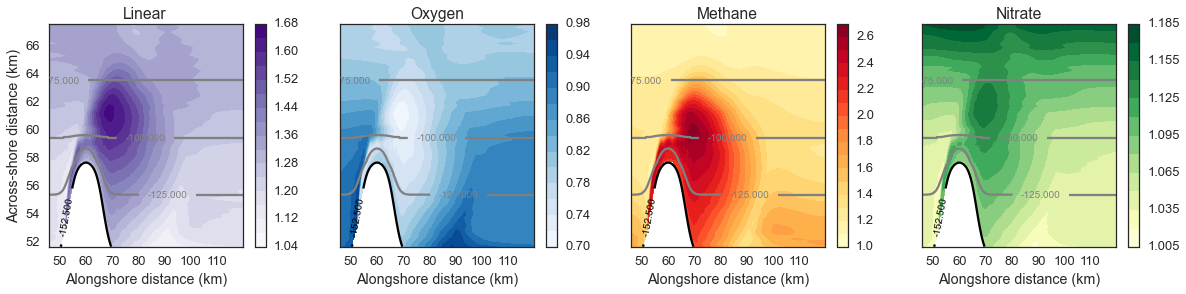

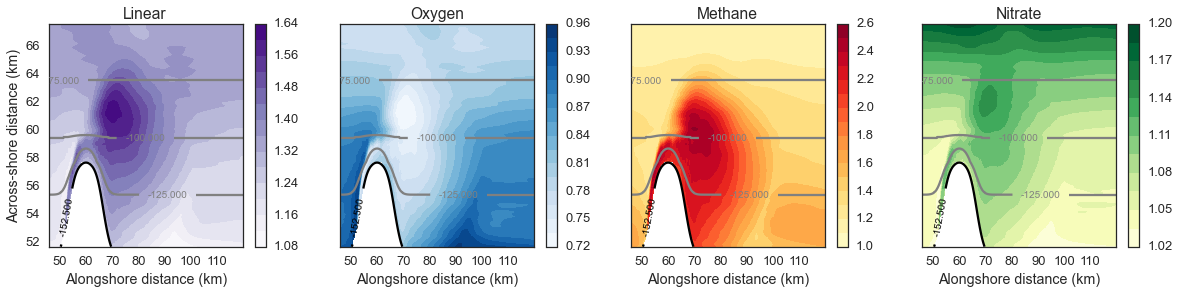

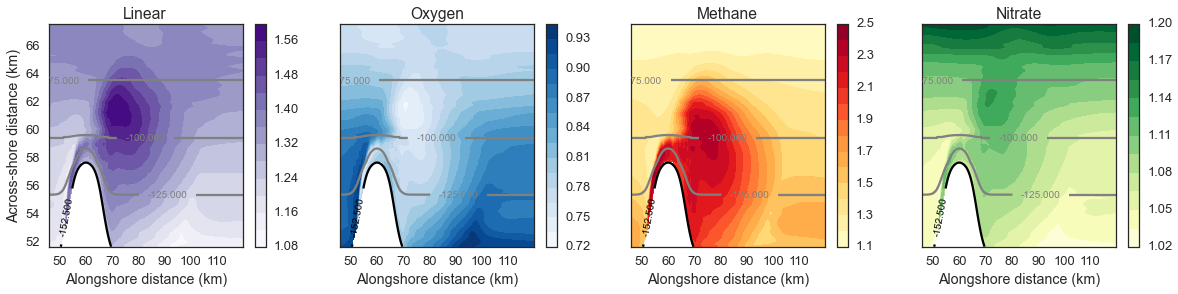

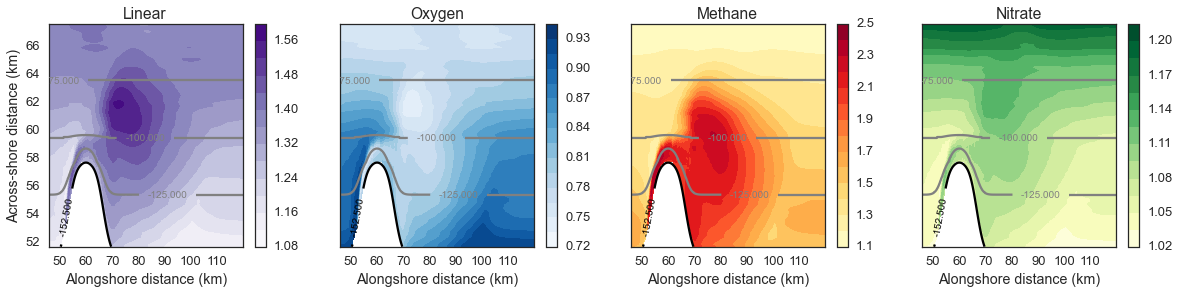

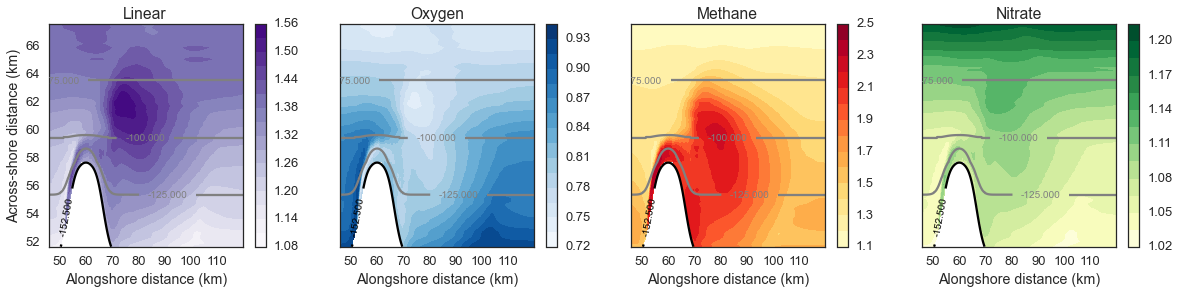

In [29]:
sns.set_context('talk', font_scale=1.0)

for tt in np.arange(0,19,2):
    print(tt)
    fig,((ax1),(ax2),(ax3),(ax4)) = plt.subplots(1, 4, figsize=(20, 4),  sharey=True, sharex=True)
    
    iso = ax1.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       (Conc1Filt[tt,227:300,100:])/Conc1Filt[0,227:300,100:],
                       15,
                       cmap='Purples',
                      )
    
    cax,kw = mpl.colorbar.make_axes([ax1],location='right',shrink=1)
    cb = plt.colorbar(iso, cax=cax,**kw)
    
    
    cset = ax1.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax1.clabel(cset, inline=1, fontsize=10)
    
    ax1.set_aspect('auto')
    ax1.set_title('Linear')
    ax1.set_ylabel('Across-shore distance (km)')
    ax1.set_xlabel('Alongshore distance (km)')
    
    #-------------------------------------------------------------------------------------------------------------------
    iso2 = ax2.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc3Filt[tt,227:300,100:])/Conc3Filt[0,227:300,100:],
                        15,cmap='Blues',
                       )
    cax,kw = mpl.colorbar.make_axes([ax2],location='right',shrink=1)
    cb = plt.colorbar(iso2, cax=cax,**kw)
    
    
    cset = ax2.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax2.clabel(cset, inline=1, fontsize=10)
    
    ax2.set_aspect('auto')
    ax2.set_title('Oxygen')
    ax2.set_xlabel('Alongshore distance (km)')
    
    
    #-------------------------------------------------------------------------------------------------------------------
    iso3 = ax3.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc8Filt[tt,227:300,100:])/Conc8Filt[0,227:300,100:],
                        15, cmap='YlOrRd',
                       )
    cax,kw = mpl.colorbar.make_axes([ax3],location='right',shrink=1)
    cb = plt.colorbar(iso3, cax=cax,**kw)
    
    
    cset = ax3.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax3.clabel(cset, inline=1, fontsize=10)
    
    ax3.set_aspect('auto')
    ax3.set_title('Methane' %(tt/2.0))
    ax3.set_xlabel('Alongshore distance (km)')
    
    #plt.tight_layout()
    plt.show

    #-------------------------------------------------------------------------------------------------------------------
    iso4 = ax4.contourf(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                        (Conc4Filt[tt,227:300,100:])/Conc4Filt[0,227:300,100:],
                        15,cmap='YlGn',
                       )
    cax,kw = mpl.colorbar.make_axes([ax4],location='right',shrink=1)
    cb = plt.colorbar(iso4, cax=cax,**kw)
    
    
    cset = ax4.contour(xc[227:300,100:]/1000.0,yc[227:300,100:]/1000.0,
                       -bathy[227:300,100:],
                       [rc[30],-125,-100,-75,-50],
                       colors=['k','0.50','0.50','0.50','0.50'],
                       linewidth=1, rstride=2, cstride=2,zdir='z',
                      )
    ax4.clabel(cset, inline=1, fontsize=10)
    
    ax4.set_aspect('auto')
    ax4.set_title('Nitrate')
    ax4.set_xlabel('Alongshore distance (km)')
    
#fig.savefig('/ocean/kramosmu/Figures/BathyShelfBoxComplete.eps', format='eps', dpi=1000, bbox_inches='tight')